# 04_data_visualization.ipynb — Transformação de Dados

## 1. Sobre

Este é o notebook final do nosso pipeline de dados. O objetivo aqui não é mais limpar ou transformar, mas sim **ver os insights** desse trabalho.

Graças aos notebooks anteriores, temos um banco de dados PostgreSQL populado com dados limpos, normalizados e, o mais importante, **enriquecidos com features**.

Agora, vamos carregar esses dados e usá-los para construir visualizações que respondam a perguntas de negócio complexas sobre o portfólio de obras de infraestrutura no Distrito Federal.

In [34]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from wordcloud import WordCloud
import os
import sys
from pathlib import Path
from sqlalchemy import create_engine, text
from dotenv import load_dotenv

project_root = Path(os.getcwd()).resolve().parents[0]
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))

# Carrega .env
load_dotenv(override=True)

# Configura o estilo dos gráficos
sns.set_theme(style="whitegrid")

## 3. Carregamento e Preparação dos Dados

### 3.1. Conexão com o Banco de Dados

Estabelecemos a conexão com nosso banco de dados PostgreSQL usando as credenciais armazenadas no arquivo `.env`.

In [35]:
## Conectar ao BD PostgreSQL
db_user = os.getenv("PG_USER")
db_pass = os.getenv("PG_PASSWORD")
db_host = os.getenv("PG_HOST")
db_port = os.getenv("PG_PORT")
db_name = os.getenv("PG_DB")

connection_string = f'postgresql+psycopg2://{db_user}:{db_pass}@{db_host}:{db_port}/{db_name}'
engine = create_engine(connection_string)

print("Conectado ao PostgreSQL!")

Conectado ao PostgreSQL!


### 3.2. Carregamento e Unificação (Merge)

Este passo é crucial e demonstra o poder do nosso pipeline:
1.  Carregamos a tabela `dados_projetos_limpos` como nosso **DataFrame Mestre (`df_master`)**. Ela já contém 90% dos dados que precisamos (projetos únicos, valores totais, status agrupado, métricas de eficiência, etc.).
2.  Carregamos as tabelas de dimensão (`eixos`, `executores`) separadamente.
3.  **Renomeamos** as colunas de nome (`descricao`, `nome`) *antes* do merge para evitar colisões.
4.  Usamos `merge` (`how='left'`) para trazer apenas os nomes de texto (ex: "Econômico", "DNIT") para o nosso DataFrame mestre.

O resultado é o `df_viz`, um DataFrame único, limpo e pronto para ser plotado sem a necessidade de cálculos ou agregações complexas neste notebook.

In [36]:
# 1. Carregar Dados Enriquecidos
with engine.connect() as conn:
    print("Carregando tabela principal 'dados_projetos'...")
    df_master = pd.read_sql(text('SELECT * FROM dados_projetos'), conn)
    print(f"Tabela principal carregada: {df_master.shape[0]} projetos.")
    
    df_eixos_dim = pd.read_sql(text('SELECT * FROM dados_eixos'), conn)
    df_executores_dim = pd.read_sql(text('SELECT * FROM dados_executores'), conn)

# 2. Simplifica dimensões (pega o *primeiro* nome de cada)
df_eixo_primario = df_eixos_dim.drop_duplicates(subset='id_unico')
df_executor_primario = df_executores_dim.drop_duplicates(subset='id_unico')

# Renomeia as colunas ANTES do merge para evitar colisão (Tive muito erro nisso)
df_eixo_primario = df_eixo_primario.rename(columns={'descricao': 'eixo_nome'})
df_executor_primario = df_executor_primario.rename(columns={'nome': 'executor_nome'})

# Cria o DataFrame de Análise final (df_viz)
df_viz = df_master.merge(
    df_eixo_primario[['id_unico', 'eixo_nome']],  
    on='id_unico', 
    how='left'
)
df_viz = df_viz.merge(
    df_executor_primario[['id_unico', 'executor_nome']], 
    on='id_unico', 
    how='left'
)

# Renomeia a coluna 'nome' original (do projeto) para clareza
df_viz = df_viz.rename(columns={'nome': 'nome_projeto'})

print(f"DataFrame de visualização (df_viz) criado com {df_viz.shape[0]} linhas.")

Carregando tabela principal 'dados_projetos'...
Tabela principal carregada: 683 projetos.
DataFrame de visualização (df_viz) criado com 683 linhas.


## 4. Visualizações

### 4.1 Visão Geral: Diagnóstico da Situação dos Projetos (Dados Brutos)

Como primeiro passo da nossa análise, é crucial entender a "saúde" do portfólio de projetos. A melhor forma de fazer isso é olhando a distribuição de todos os projetos em suas respectivas categorias de **`situacao`**.

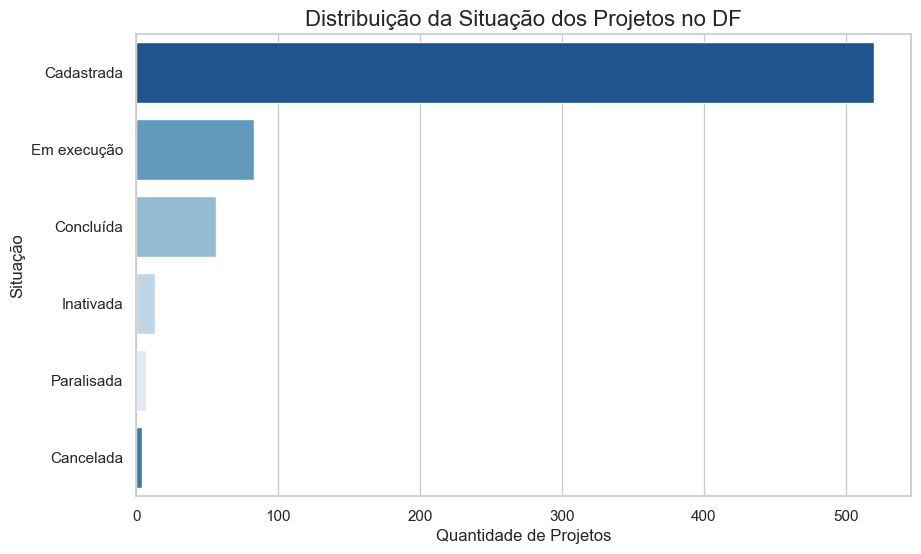

In [37]:
plt.figure(figsize=(10, 6))
sns.countplot(
    data=df_viz, 
    y='situacao', 
    order=df_viz['situacao'].value_counts().index,
    hue='situacao',  # adiciona o hue
    palette='Blues_r',
    dodge=False       # impede barras duplicadas
)
plt.title('Distribuição da Situação dos Projetos no DF', fontsize=16)
plt.xlabel('Quantidade de Projetos', fontsize=12)
plt.ylabel('Situação', fontsize=12)
plt.show()

📌 Este gráfico revela um **gargalo severo** no pipeline de projetos, com 520 (a maioria esmagadora) **parados na fase de "Cadastrada"**. Isso demonstra um acúmulo massivo no planejamento que não está se convertendo em obras "Em execução" (83) ou "Concluídas" (56). A conclusão principal é que o desafio não é a falha dos projetos, mas sim o **fato de eles nunca começarem**.

### 4.2 Análise de Série Temporal Combinada (Eixo Duplo)

Aqui, combinamos as duas métricas-chave ao longo do tempo: O **volume de investimento (R$)** e a **quantidade de projetos**.

**Argumento da Visualização:**
Essas duas métricas têm escalas totalmente diferentes (bilhões vs. dezenas). Plotá-las no mesmo eixo "esmagaria" a linha de quantidade.
A solução é um **Gráfico de Eixo Duplo**:
* **Eixo Esquerdo (Barras):** Mostra o `valor_total_investimento` em R$.
* **Eixo Direito (Linha):** Mostra a `contagem_projetos`.

Este gráfico argumenta que um ano com alto investimento não significa necessariamente um ano com muitos projetos (pode ser um ano de megaprojetos, com barra alta e linha baixa), e vice-versa.

In [38]:
## 7. Análise de Série Temporal Combinada

# 1. Agrupa por ano (coluna JÁ EXISTE) e conta os projetos
df_contagem = df_viz.groupby('ano_inicio_previsto')['id_unico'].count().reset_index()
df_contagem = df_contagem.rename(columns={'id_unico': 'contagem_projetos'})

# 2. Agrupa por ano (coluna JÁ EXISTE) e soma o valor (coluna JÁ EXISTE)
df_soma = df_viz.groupby('ano_inicio_previsto')['valor_total_investimento'].sum().reset_index()

# 3. Junta os dois DataFrames
df_combo = pd.merge(df_contagem, df_soma, on='ano_inicio_previsto', how='outer').fillna(0)
df_combo = df_combo[(df_combo['ano_inicio_previsto'] > 2010) & (df_combo['ano_inicio_previsto'] < 2026)]

# 4. Cria a figura com eixo Y secundário (código de plotagem inalterado)
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Gráfico de Barras (Investimento)
fig.add_trace(
    go.Bar(
        x=df_combo['ano_inicio_previsto'],
        y=df_combo['valor_total_investimento'],
        name='Investimento Total (R$)',
        marker_color='rgb(55, 83, 109)'
    ),
    secondary_y=False,
)

# Gráfico de Linha (Quantidade)
fig.add_trace(
    go.Scatter(
        x=df_combo['ano_inicio_previsto'],
        y=df_combo['contagem_projetos'],
        name='Quantidade de Projetos',
        marker_color='rgb(255, 127, 14)'
    ),
    secondary_y=True,
)

# Configura Títulos e Eixos
fig.update_layout(
    title_text='Investimento Total (Barras) vs. Quantidade de Projetos (Linha) por Ano',
    xaxis_title='Ano de Início Previsto',
)
fig.update_xaxes(type='category')
fig.update_yaxes(title_text='Investimento Total Previsto (R$)', secondary_y=False)
fig.update_yaxes(title_text='Quantidade de Projetos', secondary_y=True)

fig.show()

![Investimento vs Quantidade](./assets/investimento_projeto_por_ano.png)

📌 Este gráfico de eixo duplo expõe uma **desconexão** crucial entre o **volume de investimento** (barras) e a **quantidade de projetos** (linha). O ano de 2023 se destaca como uma anomalia extrema: um pico massivo de 90 projetos cadastrados, que correspondeu a um dos menores volumes financeiros do período.

### 4.3 Análise Proporcional: Onde o Dinheiro Está Concentrado?

Esta visualização foca em mostrar a proporção do investimento total para cada Eixo Estratégico.

**Argumento da Visualização:**
Escolhemos um Treemap. O tamanho de cada caixa é diretamente proporcional ao `valor_total_investimento`.

Para melhorar a estética, usamos a coluna `eixo_curto` (que criamos para este gráfico) para o rótulo visual, evitando poluição. No entanto, o *tooltip* (ao passar o mouse) usa o `hovertemplate` para mostrar o nome completo e o valor exato.

In [39]:
# 1. Preparacao dos dados
df_plot = df_viz.dropna(subset=['valor_total_investimento', 'eixo_nome']).copy()

# Cria uma nova coluna 'eixo_curto'. Se o nome tiver mais de 25 caracteres,
df_plot['eixo_curto'] = np.where(
    df_plot['eixo_nome'].str.len() > 25,
    df_plot['eixo_nome'].str.slice(0, 25) + '...',
    df_plot['eixo_nome']
)
# Isso fez com que tenha apenas 4 classes de eixo

# 2. Criação dos dados
fig = px.treemap(
    df_plot,
    # Usa o nome CURTO para o caminho (o que é desenhado)
    path=[px.Constant("Todos os Eixos"), 'eixo_curto'],
    values='valor_total_investimento',
    
    # Colore pelo nome CURTO também
    color='eixo_curto',
    
    # Passa o nome COMPLETO para o tooltip
    custom_data=['eixo_nome', 'valor_total_investimento'],
    
    title='Valor Total de Investimento por Eixo Estratégico'
)

# 3. Merlhoria Estética (o nome tava muito grande) usando HTML tags

# Adiciona o rotulo, o valor (formatado) e o percentual dentro da caixa
fig.update_traces(
    texttemplate="<b>%{label}</b><br>R$ %{value:,.2s}<br>%{percentRoot:.1%}",
    textposition='middle center',
    textfont_size=14,
    root_color="lightgrey"
)

# Customiza o TOOLTIP (ao passar o mouse) para mostrar o nome completo (nn sabia o que era tooltip)
fig.update_traces(
    hovertemplate=(
        "<b>Eixo: %{customdata[0]}</b><br>" + # Pega o nome completo
        "Investimento: R$ %{customdata[1]:,.2f}<br>" + # Valor formatado
        "Percentual do Total: %{percentRoot:.1%}" +
        "<extra></extra>" # Remove o "trace" feio
    )
)

# Ajusta margens e remove a legenda de cores (redundante)
fig.update_layout(
    margin = dict(t=50, l=25, r=25, b=25),
    showlegend=False
)

![Investimento vs Quantidade](./assets/valor_total_investimento_por_eixo.png)

📌 Este treemap expõe a **esmagadora concentração** do investimento, onde o "Eixo Econômico" sozinho responde por 58,9% (R$ 1,9B) de todo o valor. O "Eixo Social" (23,3%) é um segundo distante, provando que o portfólio, embora vasto em número, é **financeiramente dominado por esta única categoria**. Fica claro que os "megaprojetos" vistos no gráfico anterior estão quase todos alocados no eixo Econômico.

### 4.4 Análise de Custo: Qual o Perfil dos Projetos por Eixo?

A pergunta aqui é mais profunda: o perfil de custo dos projetos é diferente entre os Eixos Estratégicos?

**Argumento da Visualização:**
Um gráfico de barras de valor total poderia ser enganoso (um megaprojeto distorceria tudo). Em vez disso, usamos um gráfico de contagem empilhado que combina duas das nossas features de engenharia:
1.  **Eixo X (`eixo_nome`):** Separa os projetos por seu objetivo estratégico.
2.  **Cor (`faixa_valor`):** Quebra cada barra por faixa de custo (Pequeno, Médio, Grande, Megaprojeto).

Este gráfico nos permite argumentar, por exemplo, se o "Eixo Econômico" é composto por muitos projetos "Pequenos" ou por poucos "Megaprojetos", revelando o perfil de investimento de cada Eixo.

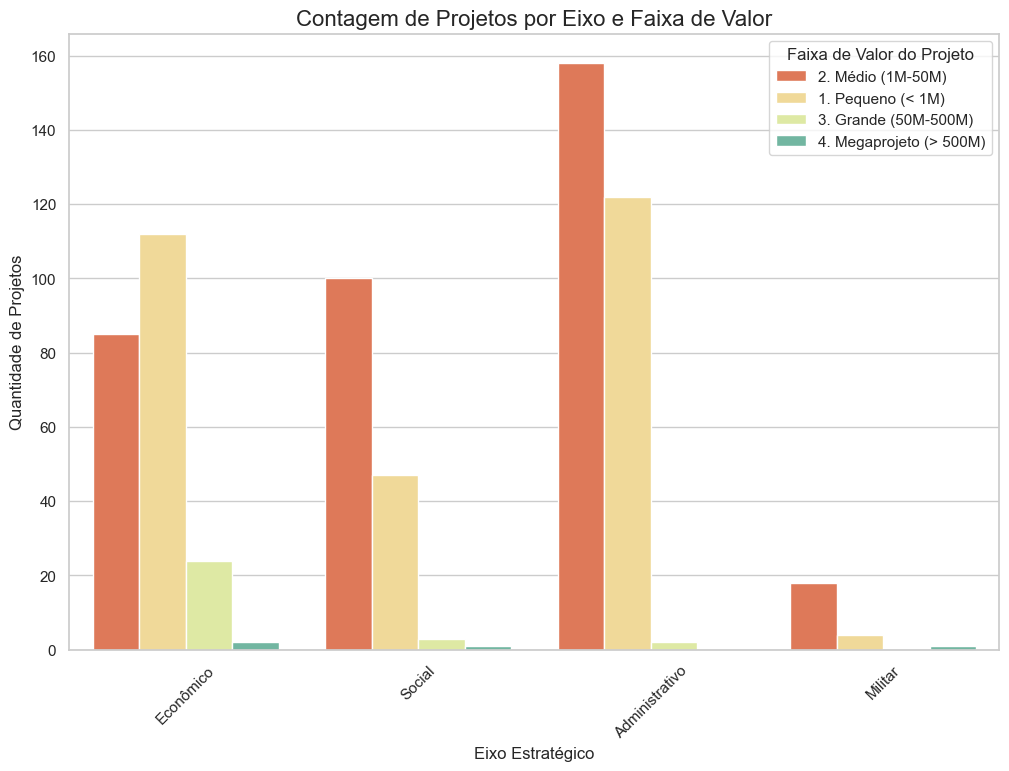

In [40]:
## 4. Análise de Investimento

# Usando as features 'faixa_valor' e 'eixo_nome'
plt.figure(figsize=(12, 8))
sns.countplot(
    data=df_viz.dropna(subset=['faixa_valor', 'eixo_nome']),
    x='eixo_nome',
    hue='faixa_valor',
    palette='Spectral'
)
plt.title('Contagem de Projetos por Eixo e Faixa de Valor', fontsize=16)
plt.xlabel('Eixo Estratégico', fontsize=12)
plt.ylabel('Quantidade de Projetos', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Faixa de Valor do Projeto')
plt.show()

📌 Este gráfico **explica perfeitamente o "porquê"** do treemap anterior: o "Eixo Econômico" domina o investimento (64,9%) não por ter muitos projetos, mas por seus **poucos projetos serem os de maior custo** ("Grandes" e "Megaprojetos"). Em contraste gritante, o "Eixo Administrativo" tem, de longe, a maior quantidade de projetos (menores de 50M), mas seu impacto financeiro é mínimo por serem quase exclusivamente "Pequenos" e "Médios", confirmando a concentração do capital em pouquíssimos projetos de alto custo.

### 4.5 Análise de Eficiência: Qual o Impacto Social por Real Gasto?

Esta é uma das nossas visualizações de insight mais importantes. Não queremos saber apenas quais projetos são caros ou quantos empregos geram, mas sim: **Quais projetos geram mais empregos para cada R$ 1 milhão investido?**

**Argumento da Visualização:**
Este gráfico só é possível graças à feature `empregos_por_milhao_brl` que criamos.
Usamos um gráfico de barras horizontais para ranquear o "Top 10" projetos mais eficientes. O gráfico argumenta que, muitas vezes, o maior impacto social não vem dos megaprojetos, mas sim de projetos menores e mais focados, que são revelados por esta métrica.

> Ao passar o mouse nas barras você consegue visualizar os dados específicos de cada um.

In [41]:
## 5. Análise de Eficiência (Empregos vs. Investimento)

# A coluna 'empregos_por_milhao_brl' JÁ EXISTE!

# 1. Seleciona os Top 10 (filtrando nulos)
df_top10 = df_viz.dropna(subset=['empregos_por_milhao_brl', 'nome_projeto']) \
                 .nlargest(10, 'empregos_por_milhao_brl')

# 2. Visualização (código de plotagem inalterado, dados muito mais simples)
fig = px.bar(
    df_top10.sort_values('empregos_por_milhao_brl', ascending=True), 
    x='empregos_por_milhao_brl',
    y='nome_projeto',
    orientation='h',
    title='Top 10 Projetos ÚNICOS por Eficiência (Empregos Gerados por R$ 1 Milhão Investido)',
    hover_data={
        'nome_projeto': False, 
        'valor_total_investimento': ':.2s', 
        'qdt_empregos_gerados': True,
        'empregos_por_milhao_brl': ':.1f'
    },
    text='empregos_por_milhao_brl'
)

# Lógica para dar espaço para as labels (inalterada)
max_valor_label = df_top10['empregos_por_milhao_brl'].max()
x_axis_max_com_buffer = max_valor_label * 1.25 

fig.update_layout(
    xaxis_title='Empregos Gerados por R$ 1 Milhão Investido',
    yaxis_title='Nome do Projeto',
    yaxis={'categoryorder':'total ascending'},
    xaxis_range=[0, x_axis_max_com_buffer]
)
fig.update_traces(texttemplate='%{text:.1f}', textposition='outside')
fig.show()

![Investimento vs Quantidade](./assets/top_10_projetos_por_eficiencia.png)

📌 Este gráfico é crucial, pois mede o principal **retorno social do investimento governamental**: a geração de empregos. Ele prova que a **maior eficiência** (empregos por real gasto) não está nos megaprojetos do "Eixo Econômico", mas sim **em obras de infraestrutura social**, como a "Construção de Unidade Básica de Saúde", que se destaca com uma eficiência massiva de mais de 140 empregos por milhão. Fica claro que, para maximizar o impacto social direto, o investimento em projetos comunitários (saúde, creches, pavimentação) é muito mais eficaz.

### 4.6 Análise de Execução: Quem Gerencia o Maior Volume de Investimentos?

Após analisar "o quê" (Eixos) e "onde" (Situação), a próxima pergunta lógica é "**quem**?". Quais entidades ou órgãos são os principais responsáveis por executar (e, portanto, gerenciar) o maior volume financeiro em projetos de infraestrutura no DF?

**Argumento da Visualização:**
Para responder a isso, não basta contar o número de projetos por executor (um órgão pode ter 100 projetos pequenos). Precisamos **somar o valor** desses projetos.

1.  **Agregação:** Agrupamos os dados pelo `nome_exec` (o nome do executor que unimos no início) e usamos `.sum()` na coluna `valor_total_investimento`.
2.  **Ranqueamento:** Selecionamos os 10 maiores (`.nlargest(10)`) para focar nos principais *players*.
3.  **Visualização:** Um gráfico de barras horizontais (`barh`) é a escolha ideal para um "Top 10", pois dá espaço para a leitura dos nomes dos executores, e o comprimento da barra é uma representação visual clara do volume financeiro.
4.  **Formatação:** Para tornar o eixo X (Valor) legível, aplicamos um formatador que converte números longos (ex: 5000000000) em um formato de moeda amigável (ex: "R$ 5.0 Bi" ou "R$ 500.0 Mi").

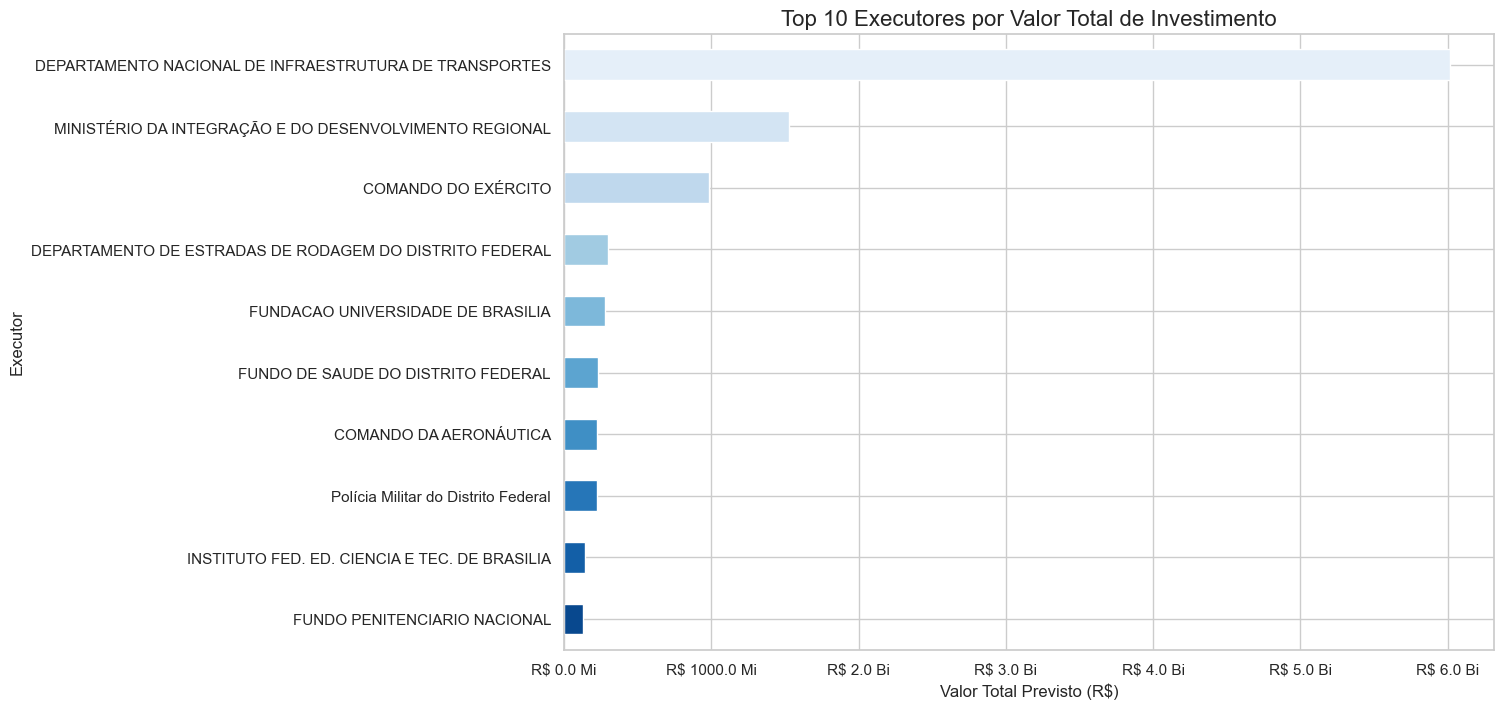

In [42]:
# Agrupando por nome do executor e somando o valor
top_10_executores = df_viz.groupby('executor_nome')['valor_total_investimento'] \
                        .sum().nlargest(10).sort_values()

plt.figure(figsize=(12, 8))
top_10_executores.plot(kind='barh', color=sns.color_palette('Blues_r', 10))
plt.title('Top 10 Executores por Valor Total de Investimento', fontsize=16)
plt.xlabel('Valor Total Previsto (R$)', fontsize=12)
plt.ylabel('Executor', fontsize=12) # O label do eixo Y está correto

# Formata o eixo X ](Milhões/Bilhões)
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'R$ {x/1e9:.1f} Bi' if x > 1e9 else f'R$ {x/1e6:.1f} Mi'))
plt.show()

📌 Este gráfico de barras evidencia a **extrema concentração de capital** no Departamento Nacional de Infraestrutura de Transportes (DNIT), que, com quase R$ 6,0 Bilhão, não é apenas o líder, mas um ponto fora da curva. O DNIT supera em **mais de 4 vezes** o segundo colocado (Ministerio da Integração e do Desenvolvimento Regional), provando que o portfólio é financeiramente dominado pela infraestrutura de transportes.

### 4.7 Análise de Texto: Quais os Temas Emergentes?

Por fim, realizamos uma análise exploratória nos dados não-estruturados (texto). Nâo a informação relevate para ser extraida, mas é visualmente intrigante (na minha opnião).

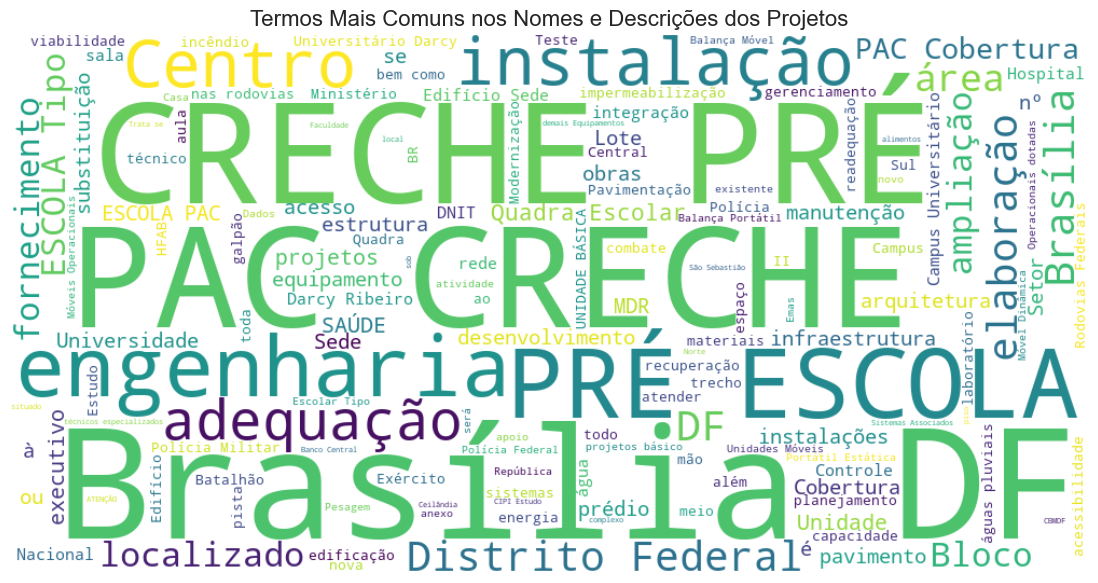

In [43]:
# 1. Concatena todo o texto em uma única string
text_nomes = " ".join(nome for nome in df_viz.nome_projeto.fillna(''))
text_descricoes = " ".join(desc for desc in df_viz.descricao.fillna(''))
text_completo = text_nomes + " " + text_descricoes

# 2. Define stopwords (palavras comuns a ignorar)
stopwords = set([
    'de', 'do', 'da', 'para', 'em', 'Contratação', 'Serviços', 'no', 'na', 
    'Obra', 'Projeto', 'Execução', 'serviço', 'contrato', 'empresa', 'especializada',
    'a', 'o', 'e', 'que', 'com', 'por', 'os', 'as', 'dos', 'das', 'uma', 'um',
    'realização', 'aquisição', 'prestação', 'mediante', 'conforme', 'objeto',
    'município', 'através', 'Construção', "Reforma", "Sistema", "Implantação"
])

# 3. Gera a Nuvem de Palavras
wordcloud = WordCloud(
    stopwords=stopwords,
    background_color="white",
    width=1000,
    height=500,
    max_words=150,       
    colormap='viridis',    
    collocations=True        # Agrupar palavras (ex: "BR-060")
).generate(text_completo)

# 4. Plota a imagem
plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Termos Mais Comuns nos Nomes e Descrições dos Projetos', fontsize=16)
plt.show()

> Grafico Visualmente Interessante (não muito informativo)